In [20]:
# Cell 0: Setup
import os
import random
import cv2  # OpenCV for video processing
import time

# For inference with YOLO (assuming you use ultralytics)
from ultralytics import YOLO

# Define directory paths (modify as per your folder structure)
test_videos_dir = 'data/test_raw'  # Directory containing your test videos
extracted_frames_dir = 'data/test_frames3'  # Directory to save extracted frames

# Create folder if it doesn't exist
os.makedirs(extracted_frames_dir, exist_ok=True)


In [8]:
# select 3 random vids
import random
random.seed(162)

# Cell 1: Randomly choose 3 candidate videos
all_videos = [f for f in os.listdir(test_videos_dir) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
print(f"Total videos found: {len(all_videos)}")

# Select 3 random videos (ensure there are at least 3)
num_candidates = 3
candidate_videos = random.sample(all_videos, min(num_candidates, len(all_videos)))
print("Selected candidate videos:")
for vid in candidate_videos:
    print(vid)



Total videos found: 10
Selected candidate videos:
bicycle_test.mp4
car_test.mp4
people_test.mp4


In [21]:
# use all vids for inference
import os
candidate_videos = []

test_raw_dir = r'C:\Users\redoks\Documents\skripzii\data\test_raw'
candidate_videos = [f for f in os.listdir(test_raw_dir) if f.lower().endswith('.mp4')]
candidate_videos = [vid for vid in candidate_videos if vid not in ['bus_test.mp4', 'boat_test.mp4', 'dog-chair-bottle_test.mp4','table_test.mp4']]
print(f"Total videos found: {len(candidate_videos)}")

special_candidate = ['bus_test.mp4', 'boat_test.mp4', 'dog-chair-bottle_test.mp4']
fastframe_candidate = ['table_test.mp4']



Total videos found: 6


In [ ]:
import random
random.seed(162)

# Cell 2: Extract one frame from each segment
# Define the segment length and the gap between segments
segment_length = 6   # seconds per segment
segment_gap = 1      # gap between segments, so segments start at 0, 7, 13, etc.
special_length = 2 # for special candidates (bus and boat)
fast_length = 1 # for fast frame candidates (table)

# We'll choose the middle of each segment. For a 6-sec segment, the midpoint is 3 seconds after the segment's start.
def extract_segment_frames(video_path, output_dir, seg_length, seg_gap):
    cap = cv2.VideoCapture(video_path)
    
    # Get FPS and total frame count
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_sec = total_frames / video_fps
    print(f"Video: {os.path.basename(video_path)} | FPS: {video_fps:.2f} | Duration: {duration_sec:.2f}s")
    
    # Calculate the start times for segments; segments start at times 0, (seg_length + seg_gap), (2*(seg_length+seg_gap)), etc.
    segment_interval = seg_length + seg_gap
    segment_starts = [t for t in range(0, int(duration_sec), segment_interval) if t + seg_length <= duration_sec]
    
    print(f"Number of segments to extract: {len(segment_starts)}")
    
    # For each segment, choose the midpoint frame (start time + seg_length/2)
    for seg_start in segment_starts:
        target_time = seg_start + seg_length / 2  # in seconds
        target_frame_index = int(target_time * video_fps)
        
        # Set the video capture position to the target frame index
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_index)
        ret, frame = cap.read()
        if ret:
            # Define filename and save the extracted frame
            frame_filename = os.path.join(output_dir, f"frame_{target_frame_index:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            print(f"Saved frame at {target_time:.1f}s (Frame {target_frame_index}) -> {frame_filename}")
        else:
            print(f"Failed to capture frame at {target_time:.1f}s (Frame {target_frame_index})")
    
    cap.release()

# Process each candidate video
for vid_name in candidate_videos:
    vid_path = os.path.join(test_videos_dir, vid_name)
    # Create a subdirectory for frames for this video
    video_frames_dir = os.path.join(extracted_frames_dir, os.path.splitext(vid_name)[0])
    os.makedirs(video_frames_dir, exist_ok=True)
    
    # Extract frames with non-continuous segments
    extract_segment_frames(vid_path, video_frames_dir, segment_length, segment_gap)
    print()

# Process each candidate video
for vid_name in special_candidate:
    vid_path = os.path.join(test_videos_dir, vid_name)
    # Create a subdirectory for frames for this video
    video_frames_dir = os.path.join(extracted_frames_dir, os.path.splitext(vid_name)[0])
    os.makedirs(video_frames_dir, exist_ok=True)
    
    # Extract frames with non-continuous segments
    extract_segment_frames(vid_path, video_frames_dir, special_length, segment_gap)
    print()

# Process each candidate video
for vid_name in fastframe_candidate:
    vid_path = os.path.join(test_videos_dir, vid_name)
    # Create a subdirectory for frames for this video
    video_frames_dir = os.path.join(extracted_frames_dir, os.path.splitext(vid_name)[0])
    os.makedirs(video_frames_dir, exist_ok=True)
    
    # Extract frames with non-continuous segments
    extract_segment_frames(vid_path, video_frames_dir, fast_length, segment_gap)
    print()


Video: table_test.mp4 | FPS: 25.00 | Duration: 14.60s
Number of segments to extract: 7
Saved frame at 0.5s (Frame 12) -> data/test_frames3\table_test\frame_0012.jpg
Saved frame at 2.5s (Frame 62) -> data/test_frames3\table_test\frame_0062.jpg
Saved frame at 4.5s (Frame 112) -> data/test_frames3\table_test\frame_0112.jpg
Saved frame at 6.5s (Frame 162) -> data/test_frames3\table_test\frame_0162.jpg
Saved frame at 8.5s (Frame 212) -> data/test_frames3\table_test\frame_0212.jpg
Saved frame at 10.5s (Frame 262) -> data/test_frames3\table_test\frame_0262.jpg
Saved frame at 12.5s (Frame 312) -> data/test_frames3\table_test\frame_0312.jpg



# TEST CLASS CONVERTER

In [ ]:
# TEST
# names: ['Bicycle', 'Car', 'Motorbike', 'People']
# 0, 1, 2, 3

# ACTUAL
#names: ['Bicycle', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 'Chair', 'Cup', 'Dog', 'Motorbike', 'People', 'Table']
# 0, 4, 9, 10

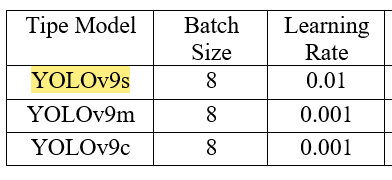

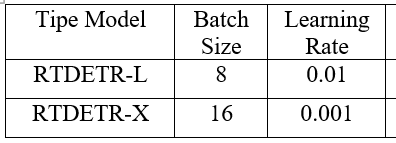

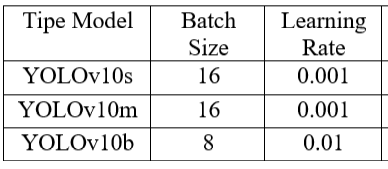

# 2nd way to inference

In [ ]:
from ultralytics import YOLO
from ultralytics import RTDETR
import time
import os

# --- Configurable Paths ---
BASE_YOLO10_DIR  = r"C:\Users\redoks\Documents\skripzii\products6k\YOLOv10"
BASE_YOLO9_DIR  = r"C:\Users\redoks\Documents\skripzii\products6k\YOLOv9"
BASE_RTD_DIR   = r"C:\Users\redoks\Documents\skripzii\products6k\RTDETR"
BASE_DATA_DIR  = r"C:\Users\redoks\Documents\skripzii\data\test_ready2"
PROJECT_ROOT   = r"runs/detect/VID-static_conf"

os.makedirs(PROJECT_ROOT, exist_ok=True)

# Performance log file (will be reset each run)
perf_file = os.path.join(PROJECT_ROOT, "performances.txt")
with open(perf_file, 'w') as f:
    f.write("=== Evaluation Performance Summary ===\n\n")

# --- Variants ---
t_values = ['day','night']

model_configs = {
    # YOLOv10 family
    'YOLOv10s': {'batch': '16', 'lr': '0.001'},
    'YOLOv10m': {'batch': '16', 'lr': '0.001'},
    'YOLOv10b': {'batch': '8',  'lr': '0.01'},
    # YOLOv9 family
    'YOLOv9s':  {'batch': '8',  'lr': '0.01'},
    'YOLOv9m':  {'batch': '8',  'lr': '0.001'},
    'YOLOv9c':  {'batch': '8',  'lr': '0.001'},
    # RTDETR family
    'RTDETR-L': {'batch': '8',  'lr': '0.01'},
    'RTDETR-X': {'batch': '16', 'lr': '0.001'},
}

# --- Main Loop ---
for t in t_values:
    data_yaml = os.path.join(BASE_DATA_DIR, f"data-{t}.yaml")

    for model_name, cfg in model_configs.items():
        batch_size = cfg['batch']
        lr_value   = cfg['lr']

        # select correct class & base directory
        if model_name.startswith('RTDETR'):
            base_dir   = BASE_RTD_DIR
            ModelClass = RTDETR

        elif model_name.startswith('YOLOv9'):
            base_dir   = BASE_YOLO9_DIR
            ModelClass = YOLO
        
        else:
            base_dir = BASE_YOLO10_DIR
            ModelClass = YOLO

        # construct weights path
        weights_path = os.path.join(
            base_dir,
            model_name,
            f"batch{batch_size}_lr{lr_value}",
            "weights",
            "best.pt"
        )

        run_name = f"{model_name}-{t}"
        print(f"\n▶ Running {run_name} (batch={batch_size}, lr={lr_value})")

        # load model
        model = ModelClass(weights_path)

        # evaluate
        start_time = time.time()
        results = model.val(
            data       = data_yaml,
            split      = 'test',
            conf       = 0.25,
            iou        = 0.5,
            imgsz      = 640,
            device     = 'cpu',
            cache      = False,
            batch      = 56,
            save       = True,
            project    = PROJECT_ROOT,
            name       = run_name,
            exist_ok   = True,
            save_txt   = True,
            save_conf  = True,
            plots      = True,
        )
        elapsed = time.time() - start_time

        # print summary
        summary = (
            f"=== Result: {run_name} ===\n"
            f"mAP@0.5:       {results.box.map50:.4f}\n"
            f"mAP@0.5:0.95:  {results.box.map:.4f}\n"
            f"Inference:     {results.speed['inference']:.2f} ms/img\n"
            f"Total elapsed: {elapsed:.2f} sec\n"
            + "-"*40 + "\n"
        )
        print(summary)

        # append to performance log
        with open(perf_file, 'a') as f:
            f.write(summary)



▶ Running YOLOv10s-day (batch=16, lr=0.001)
Ultralytics 8.3.107  Python-3.12.0 torch-2.6.0+cpu CPU (Intel Core(TM) i5-8265U 1.60GHz)
YOLOv10s summary (fused): 129 layers, 8,044,248 parameters, 0 gradients, 24.5 GFLOPs


val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-day\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.45s/it]


                   all         56        533      0.527      0.259      0.396       0.21
               Bicycle         12         21      0.783      0.429      0.619      0.179
                  Boat          7         12      0.349     0.0833      0.237      0.142
                Bottle         14         26        0.2     0.0385      0.106     0.0634
                   Bus          3          3        0.5      0.333      0.333      0.167
                   Car          8         14      0.549        0.5      0.574      0.273
                   Cat          9         23          1       0.13      0.565      0.286
                 Chair         19        119      0.512      0.118      0.298      0.222
                   Cup          6        114          0          0          0          0
                   Dog          6         12      0.271      0.167      0.243      0.198
             Motorbike          6         18      0.726      0.444      0.604      0.442
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-day\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:30<00:00, 30.36s/it]


                   all         56        533      0.671       0.33      0.505      0.259
               Bicycle         12         21      0.875      0.333      0.619      0.286
                  Boat          7         12        0.5     0.0833      0.313      0.157
                Bottle         14         26      0.778      0.269      0.546      0.196
                   Bus          3          3       0.25      0.333      0.167        0.1
                   Car          8         14       0.35        0.5      0.497      0.253
                   Cat          9         23       0.75      0.391      0.571      0.184
                 Chair         19        119      0.647       0.37      0.542      0.341
                   Cup          6        114          1     0.0439      0.522      0.219
                   Dog          6         12        0.8      0.333        0.6      0.441
             Motorbike          6         18        0.5      0.278      0.351      0.133
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-day\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:44<00:00, 44.67s/it]


                   all         56        533      0.603      0.341       0.49      0.225
               Bicycle         12         21        0.9      0.429      0.666     0.0994
                  Boat          7         12      0.667      0.333      0.444      0.144
                Bottle         14         26      0.417      0.192      0.327      0.123
                   Bus          3          3      0.667      0.667      0.777      0.311
                   Car          8         14      0.615      0.571      0.696      0.385
                   Cat          9         23        0.7      0.304      0.521      0.262
                 Chair         19        119      0.641       0.21      0.406      0.289
                   Cup          6        114          0          0          0          0
                   Dog          6         12        0.8      0.333      0.582      0.383
             Motorbike          6         18      0.444      0.222      0.363      0.201
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-day\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.87s/it]


                   all         56        533      0.472      0.309      0.397      0.175
               Bicycle         12         21      0.666      0.381      0.529      0.126
                  Boat          7         12      0.377       0.25      0.292      0.133
                Bottle         14         26      0.291      0.154      0.198     0.0435
                   Bus          3          3      0.333      0.333      0.446      0.223
                   Car          8         14      0.305      0.429      0.403      0.227
                   Cat          9         23      0.793      0.435      0.578      0.227
                 Chair         19        119      0.556      0.353      0.421      0.233
                   Cup          6        114          0          0          0          0
                   Dog          6         12      0.658      0.322      0.526      0.274
             Motorbike          6         18      0.399      0.278      0.369      0.153
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-day\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:35<00:00, 35.55s/it]


                   all         56        533      0.655      0.448      0.574      0.306
               Bicycle         12         21          1      0.571      0.786      0.313
                  Boat          7         12      0.636      0.583      0.634      0.393
                Bottle         14         26      0.692      0.346      0.532      0.196
                   Bus          3          3       0.25      0.333      0.418      0.334
                   Car          8         14      0.692      0.643      0.745       0.32
                   Cat          9         23      0.667      0.348      0.508      0.329
                 Chair         19        119      0.553      0.437      0.498      0.313
                   Cup          6        114      0.478     0.0965      0.265     0.0495
                   Dog          6         12      0.714      0.417      0.625       0.51
             Motorbike          6         18      0.429      0.333      0.307     0.0967
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-day\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:50<00:00, 50.20s/it]


                   all         56        533      0.671      0.383      0.532      0.267
               Bicycle         12         21      0.861      0.286      0.553      0.258
                  Boat          7         12      0.192     0.0833      0.161      0.129
                Bottle         14         26      0.798      0.423      0.619      0.228
                   Bus          3          3          0          0          0          0
                   Car          8         14      0.785      0.714      0.769      0.305
                   Cat          9         23      0.906      0.418      0.675        0.3
                 Chair         19        119      0.789      0.471       0.62      0.393
                   Cup          6        114       0.37     0.0439      0.156     0.0206
                   Dog          6         12      0.689        0.5      0.661      0.494
             Motorbike          6         18      0.906      0.444      0.584      0.262
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-day\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [01:23<00:00, 83.36s/it]


                   all         56        533      0.572      0.352      0.363      0.149
               Bicycle         12         21      0.711      0.238       0.23     0.0491
                  Boat          7         12      0.375      0.333      0.331      0.122
                Bottle         14         26      0.582      0.192      0.202     0.0489
                   Bus          3          3      0.691      0.667      0.666      0.284
                   Car          8         14      0.665      0.643      0.655      0.243
                   Cat          9         23      0.782      0.469       0.49      0.245
                 Chair         19        119       0.74      0.328      0.361      0.149
                   Cup          6        114          0          0     0.0145    0.00434
                   Dog          6         12      0.637      0.333      0.323      0.144
             Motorbike          6         18      0.501      0.279      0.353       0.22
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-day\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [02:30<00:00, 150.87s/it]


                   all         56        533      0.628      0.452      0.492      0.253
               Bicycle         12         21      0.873      0.329      0.485      0.159
                  Boat          7         12       0.28       0.25      0.271      0.128
                Bottle         14         26      0.873      0.265      0.415      0.233
                   Bus          3          3          0          0     0.0181     0.0163
                   Car          8         14      0.592      0.857      0.852       0.44
                   Cat          9         23       0.77      0.652      0.656      0.401
                 Chair         19        119      0.673      0.588      0.628      0.333
                   Cup          6        114      0.447     0.0568      0.237     0.0812
                   Dog          6         12       0.93      0.667      0.669      0.484
             Motorbike          6         18      0.542      0.444       0.34       0.14
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-night\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<00:00, 14.91s/it]


                   all         56        533      0.548      0.271      0.414      0.206
               Bicycle         12         21      0.625      0.238       0.46     0.0995
                  Boat          7         12      0.333     0.0833      0.237      0.142
                Bottle         14         26      0.375      0.115      0.209       0.16
                   Bus          3          3        0.5      0.333      0.333        0.1
                   Car          8         14      0.556      0.714      0.756      0.395
                   Cat          9         23          1      0.348      0.674      0.287
                 Chair         19        119      0.448      0.109       0.27      0.183
                   Cup          6        114          0          0          0          0
                   Dog          6         12        0.2     0.0833      0.134     0.0803
             Motorbike          6         18          1      0.333      0.667      0.462
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-night\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:33<00:00, 33.38s/it]


                   all         56        533      0.678      0.347      0.539      0.268
               Bicycle         12         21      0.833      0.238      0.555      0.247
                  Boat          7         12       0.25     0.0833      0.157     0.0783
                Bottle         14         26       0.75      0.231       0.52      0.165
                   Bus          3          3      0.333      0.333      0.446      0.178
                   Car          8         14      0.353      0.429      0.492      0.256
                   Cat          9         23      0.923      0.522      0.726      0.305
                 Chair         19        119      0.825      0.395      0.612      0.366
                   Cup          6        114          1     0.0526      0.526      0.244
                   Dog          6         12      0.857        0.5      0.714      0.452
             Motorbike          6         18      0.545      0.333      0.433      0.163
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-night\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:44<00:00, 44.54s/it]


                   all         56        533      0.643      0.297      0.465      0.214
               Bicycle         12         21      0.833      0.238      0.548     0.0818
                  Boat          7         12      0.538      0.198      0.386      0.107
                Bottle         14         26      0.451      0.154      0.293     0.0954
                   Bus          3          3      0.973      0.667      0.777      0.389
                   Car          8         14      0.702      0.643      0.676      0.344
                   Cat          9         23          1      0.348      0.674      0.317
                 Chair         19        119      0.695      0.176      0.344      0.221
                   Cup          6        114          0          0          0          0
                   Dog          6         12        0.6       0.25      0.441      0.311
             Motorbike          6         18        0.5      0.167      0.374      0.216
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-night\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<00:00, 14.42s/it]


                   all         56        533       0.54      0.356      0.444      0.183
               Bicycle         12         21        0.6      0.286      0.483     0.0917
                  Boat          7         12        0.5      0.333      0.401      0.167
                Bottle         14         26        0.5      0.115      0.279     0.0743
                   Bus          3          3        0.4      0.667      0.567      0.267
                   Car          8         14      0.533      0.571      0.584      0.251
                   Cat          9         23      0.667      0.435      0.506      0.228
                 Chair         19        119      0.537      0.429      0.427      0.199
                   Cup          6        114          0          0          0          0
                   Dog          6         12        0.8      0.333        0.6        0.3
             Motorbike          6         18      0.667      0.333      0.529      0.198
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-night\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:34<00:00, 34.20s/it]


                   all         56        533      0.694      0.412      0.571      0.313
               Bicycle         12         21          1      0.333      0.667      0.306
                  Boat          7         12       0.75        0.5      0.624      0.385
                Bottle         14         26        0.8      0.308      0.554      0.253
                   Bus          3          3       0.25      0.333      0.418      0.293
                   Car          8         14      0.833      0.714      0.813      0.374
                   Cat          9         23      0.857      0.261      0.571      0.405
                 Chair         19        119      0.536      0.378      0.476      0.304
                   Cup          6        114      0.267     0.0351      0.143     0.0287
                   Dog          6         12      0.875      0.583      0.766      0.549
             Motorbike          6         18      0.417      0.278      0.279      0.125
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-night\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:48<00:00, 48.53s/it]


                   all         56        533      0.604      0.467       0.57      0.276
               Bicycle         12         21       0.75      0.286      0.541      0.241
                  Boat          7         12      0.286      0.167      0.231      0.131
                Bottle         14         26        0.5        0.5      0.538       0.18
                   Bus          3          3        0.5      0.333      0.501      0.351
                   Car          8         14      0.667      0.714      0.756      0.284
                   Cat          9         23      0.778      0.609      0.694      0.327
                 Chair         19        119       0.79      0.538      0.658      0.361
                   Cup          6        114      0.182     0.0175     0.0941      0.014
                   Dog          6         12      0.667      0.667       0.74      0.514
             Motorbike          6         18      0.562        0.5      0.614      0.273
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-night\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [01:18<00:00, 78.02s/it]


                   all         56        533      0.639      0.304      0.351      0.144
               Bicycle         12         21      0.178     0.0476      0.132     0.0284
                  Boat          7         12      0.371       0.25      0.247     0.0838
                Bottle         14         26      0.542      0.154      0.159     0.0518
                   Bus          3          3      0.556      0.667      0.666      0.284
                   Car          8         14      0.672      0.643       0.58      0.268
                   Cat          9         23      0.913      0.478      0.672      0.288
                 Chair         19        119      0.773      0.316      0.403      0.173
                   Cup          6        114          1          0     0.0153    0.00272
                   Dog          6         12      0.766      0.277      0.322      0.147
             Motorbike          6         18      0.731      0.222      0.328      0.179
                Peopl

val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-night\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [02:23<00:00, 143.28s/it]


                   all         56        533      0.607       0.53       0.52       0.28
               Bicycle         12         21      0.522      0.209       0.31      0.114
                  Boat          7         12      0.476       0.25      0.196      0.093
                Bottle         14         26      0.823      0.538      0.557      0.338
                   Bus          3          3       0.18      0.667      0.556      0.423
                   Car          8         14      0.526      0.857      0.891      0.443
                   Cat          9         23      0.794      0.696      0.662      0.392
                 Chair         19        119      0.617       0.63      0.586       0.31
                   Cup          6        114      0.527       0.14      0.221     0.0769
                   Dog          6         12      0.945       0.75      0.754      0.502
             Motorbike          6         18      0.455      0.278       0.25      0.103
                Peopl

# RTDETR TEST (special)

In [ ]:
def predict_images(model, base_path, x_values):
    """
    Perform predictions on a set of images using the given model.

    Args:
        model: The loaded RTDETR model.
        base_path: The base path to the images (e.g., "C:/Users/redoks/Documents/skripzii/data/test_ready2/test-day/images").
        x_values: A list of integers representing the image indices to predict.

    Returns:
        None
    # """
    for n in x_values:
        image_path = base_path.format(n=n)
        print(f"Predicting for image: {image_path}")
        
        # Perform prediction
        results = model.predict(source=image_path, save=True, conf=0.25, iou=0.5, device='cpu')
        
        # Print results summary
        print(f"Results for image {n}:")
        print(results)

# Define the base path and x values
model = RTDETR("C:/Users/redoks/Documents/skripzii/products6k/RTDETR/RTDETR-X/batch16_lr0.001/weights/best.pt")
base_path = r"C:/Users/redoks/Documents/skripzii/data/test_ready2/test-day/images/{n}.jpg"
x_values = [30, 36, 40, 43, 44, 45]

# Call the function
predict_images(model, base_path, x_values)


Predicting for image: C:/Users/redoks/Documents/skripzii/data/test_ready2/test-day/images/30.jpg

image 1/1 C:\Users\redoks\Documents\skripzii\data\test_ready2\test-day\images\30.jpg: 640x640 1 Bicycle, 8 Peoples, 1749.7ms
Speed: 7.0ms preprocess, 1749.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
Results for image 30:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Bicycle', 1: 'Boat', 2: 'Bottle', 3: 'Bus', 4: 'Car', 5: 'Cat', 6: 'Chair', 7: 'Cup', 8: 'Dog', 9: 'Motorbike', 10: 'People', 11: 'Table'}
obb: None
orig_img: array([[[120, 116, 115],
        [104, 100,  99],
        [ 99,  95,  94],
        ...,
        [ 61,  55,  96],
        [ 62,  54,  95],
        [ 62,  54,  95]],

       [[118, 114, 113],
        [104, 100,  99],
        [ 99,  95,  94],
        ...,
        [ 61,  55,  96],
        [ 62,  54,  95],
        [

# VIDEOS

In [1]:
from ultralytics import YOLO
import time
import os

# --- Configurable Paths ---
BASE_YOLO9_DIR  = r"C:\Users\redoks\Documents\skripzii\products6k\YOLOv9"
BASE_DATA_DIR   = r"C:\Users\redoks\Documents\skripzii\data\test_ready2"
PROJECT_ROOT    = r"runs/detect/VID-static_conf"

os.makedirs(PROJECT_ROOT, exist_ok=True)

# Performance log file (reset each run)
perf_file = os.path.join(PROJECT_ROOT, "performances.txt")
with open(perf_file, 'w') as f:
    f.write("=== Video Inference Performance Summary ===\n\n")

# --- Settings ---
model_name = 'YOLOv9m'
batch_size = 8
lr_value   = 0.001
conf_thresh = 0.25
imgsz = 640

# Prepare model
weights_path = os.path.join(
    BASE_YOLO9_DIR,
    model_name,
    f"batch{batch_size}_lr{lr_value}",
    "weights",
    "best.pt"
)

print(f"▶ Loading model {model_name} from {weights_path}")
model = YOLO(weights_path)

# Input folders
input_folders = [
    os.path.join(BASE_DATA_DIR, "ExDark-TEST_cropped"),
    os.path.join(BASE_DATA_DIR, "ExDark-TEST_cropped-night")
]

# --- Main Loop ---
for input_dir in input_folders:
    variant = os.path.basename(input_dir)  # 'ExDark-TEST_cropped' or 'ExDark-TEST_cropped-night'
    
    for filename in os.listdir(input_dir):
        if not filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv')):
            print(f"Skipping non-video file: {filename}")
            continue

        input_path = os.path.join(input_dir, filename)
        run_name = f"{model_name}-{variant}-{os.path.splitext(filename)[0]}"
        
        print(f"\n▶ Predicting on {input_path}...")

        start_time = time.time()

        results = model.predict(
            source=input_path,
            conf=conf_thresh,
            imgsz=imgsz,
            save=True,
            save_txt=True,
            save_conf=True,
            project=PROJECT_ROOT,
            name=run_name,
            exist_ok=True,
            device='cpu'
        )

        elapsed = time.time() - start_time

        # Save timing
        summary = (
            f"=== Video: {filename} ({variant}) ===\n"
            f"Total elapsed: {elapsed:.2f} sec\n"
            + "-"*40 + "\n"
        )
        print(summary)

        with open(perf_file, 'a') as f:
            f.write(summary)

print("✅ Video inference completed!")


▶ Loading model YOLOv9m from C:\Users\redoks\Documents\skripzii\products6k\YOLOv9\YOLOv9m\batch8_lr0.001\weights\best.pt

▶ Predicting on C:\Users\redoks\Documents\skripzii\data\test_ready2\ExDark-TEST_cropped\bicycle-test.mp4...


WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/895) C:\Users\redoks\Documents\skripzii\data\test_ready2\ExDark-TEST_cropped\bicycle-test.mp4: 384x640 2 Motorbikes, 695.3ms
video 1/1 (frame 2/895) C:\Users\redoks\Documents\skripzii\data\test_ready2\ExDark-T